In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from custom_models.ddpm import MyDDPM, MyUNet, FixedUNet
import torch
import torch.nn as nn
from utils import load_medMNIST_data
import torch.nn.functional as F

In [3]:
dataloader, dataset = load_medMNIST_data()

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/
Using downloaded and verified file: C:\Users\josem\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\bloodmnist.npz
Image size: torch.Size([3, 28, 28])
Label size: torch.Size([1])
Label values: {0, 1, 2, 3, 4, 5, 6, 7}


In [4]:
# get image size from the dataset
channels, dim_1, dim_2 = dataloader.dataset[0][0].shape

print(f"Channels: {channels}")
print(f"Dim 1: {dim_1}")
print(f"Dim 2: {dim_2}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Channels: 3
Dim 1: 28
Dim 2: 28


In [5]:
# ********** Training parameters **********
lr = 5e-5  
n_epochs = 50  

# ********** DDPM parameters **********

# Defining model
n_steps, min_beta, max_beta = 500, 10 ** -4, 0.02  # Originally used by the authors of the paper
ddpm = MyDDPM(
    FixedUNet(n_steps=n_steps, in_channels=channels), 
    n_steps=n_steps, 
    min_beta=min_beta, 
    max_beta=max_beta, 
    device=device, 
    image_chw=(channels, dim_1, dim_2)
)

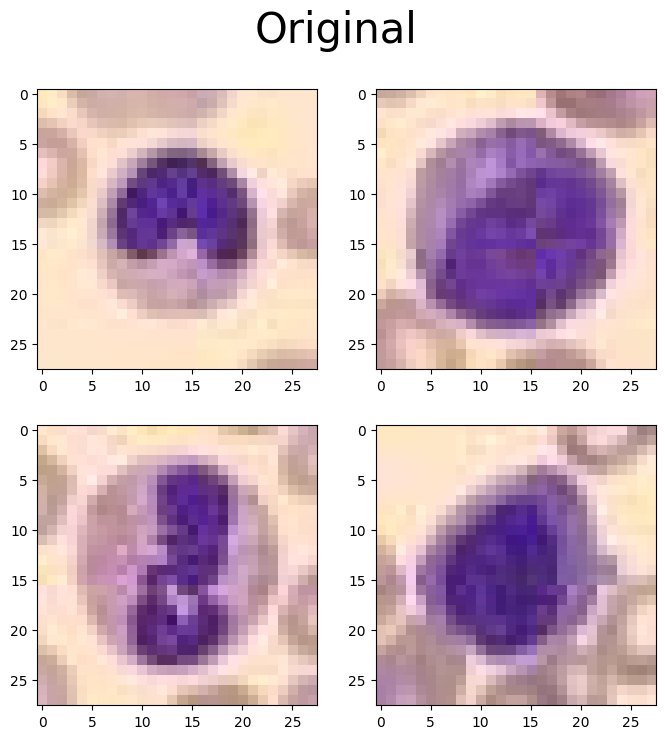

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09221223..1.0134227].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13720647..1.0112066].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0654178..1.0101386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08698776..1.014463].


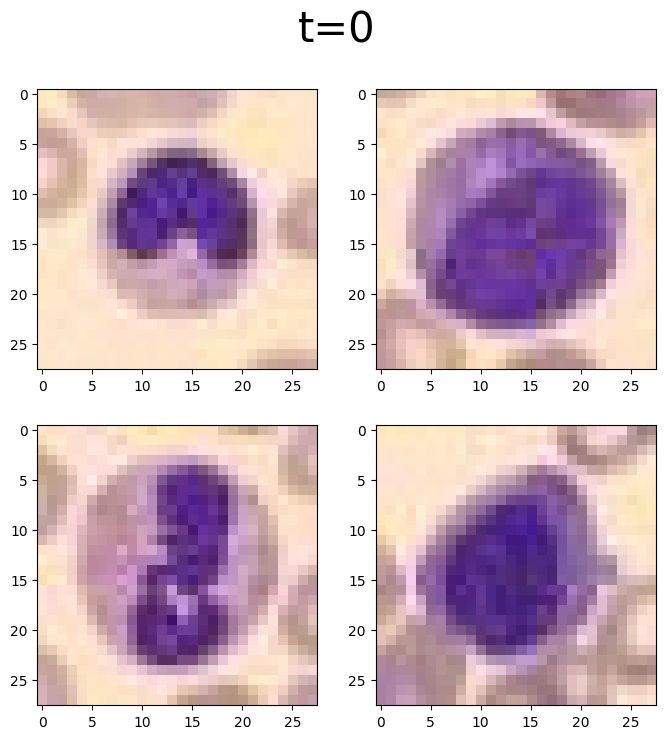

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39359772..1.6738547].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36384082..1.631218].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22732002..1.6750036].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4875949..1.5657372].


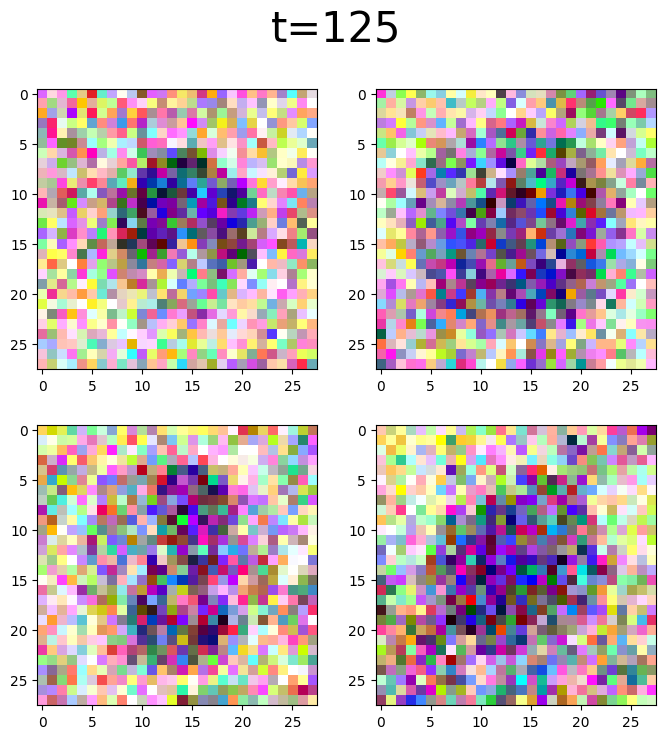

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9675431..2.060147].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81735086..2.1432357].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8705249..2.191709].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9460007..1.9839611].


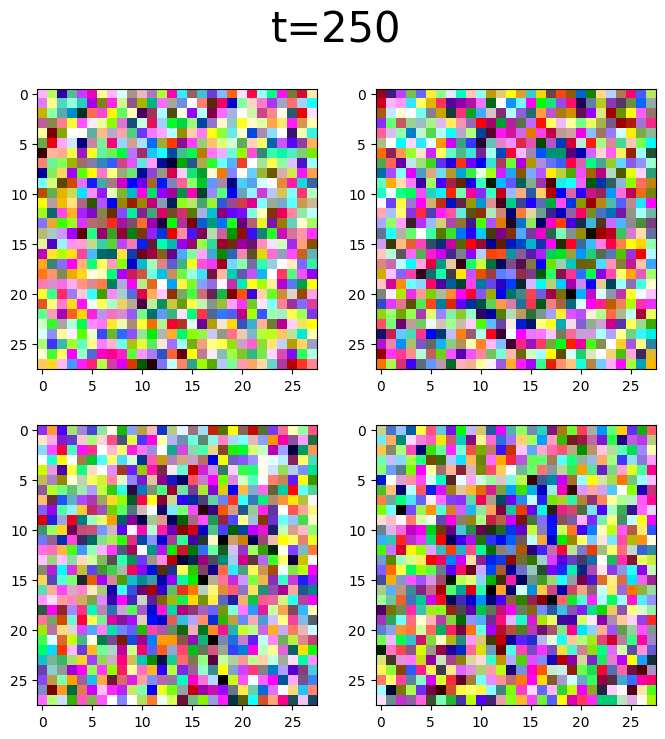

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3565702..2.3285096].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0079396..2.2967858].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5705824..2.524872].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0595883..2.137095].


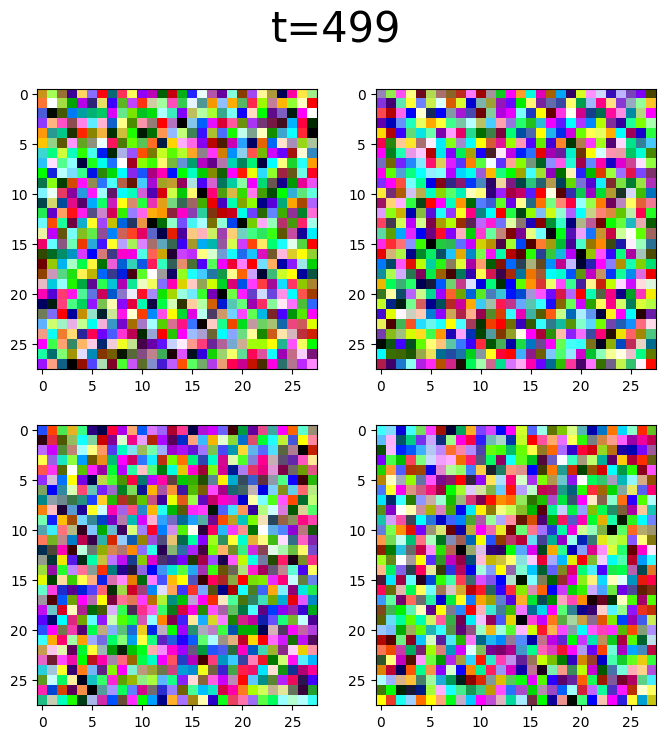

In [6]:
from custom_models.ddpm import show_images


def test_forward_process(ddpm, dataloader):
    data = next(iter(dataloader))[0][:4].to(device)
    
    # Original images
    show_images((data + 1) * 0.5, "Original")
    
    # Test different noise levels
    for t in [0, ddpm.n_steps//4, ddpm.n_steps//2, ddpm.n_steps-1]:
        noisy = ddpm(data, torch.tensor([t]*len(data)), torch.randn_like(data))
        show_images((noisy + 1) * 0.5, f"t={t}")
        
        
test_forward_process(ddpm, dataloader)
        

In [7]:

from tqdm import tqdm

from custom_models.ddpm import generate_new_images, show_images


def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        
        for batch in loader:
            x0 = batch[0].to(device)
            n = len(x0)
            
            # Ensure proper tensor shapes
            assert x0.shape[1:] == ddpm.image_chw, f"Shape mismatch: {x0.shape[1:]} vs {ddpm.image_chw}"
            
            eta = torch.randn_like(x0)
            t = torch.randint(0, ddpm.n_steps, (n,)).to(device)
            
            noisy_imgs = ddpm(x0, t, eta)
            eta_theta = ddpm.backward(noisy_imgs, t)
            
            loss = mse(eta, eta_theta)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            epoch_loss += loss.item() * len(x0) / len(loader.dataset)
        
        # Generate samples every few epochs to monitor progress
        if epoch % 10 == 0:
            with torch.no_grad():
                samples = generate_new_images(ddpm, n_samples=4, device=device)
                show_images(samples, f"Epoch {epoch}")
        
        print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}")
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save({
                'model_state_dict': ddpm.state_dict(),
                'n_steps': ddpm.n_steps,
                'image_chw': ddpm.image_chw,
                'epoch': epoch,
                'loss': epoch_loss
            }, store_path)


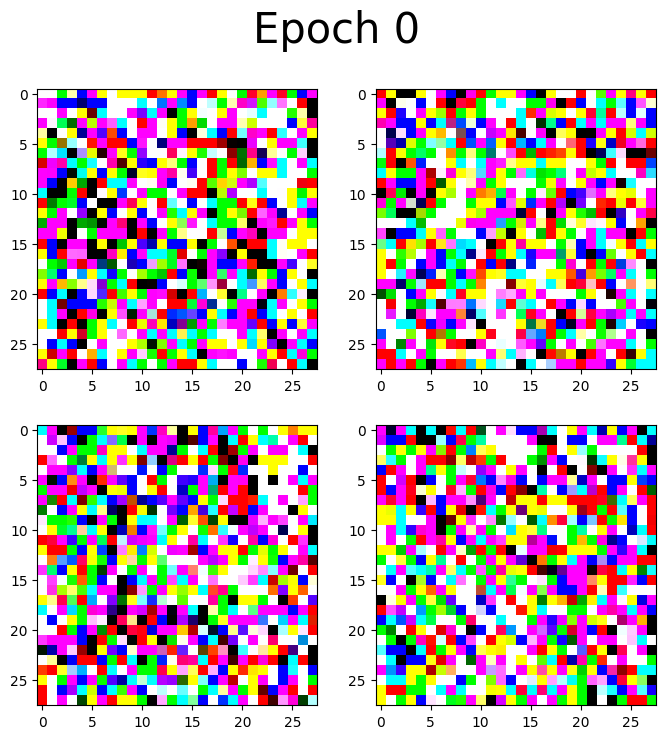

Epoch 0: Loss = 1.0020
Epoch 1: Loss = 0.4583
Epoch 2: Loss = 0.3017
Epoch 3: Loss = 0.2380
Epoch 4: Loss = 0.2044
Epoch 5: Loss = 0.1811
Epoch 6: Loss = 0.1640
Epoch 7: Loss = 0.1497
Epoch 8: Loss = 0.1398
Epoch 9: Loss = 0.1278


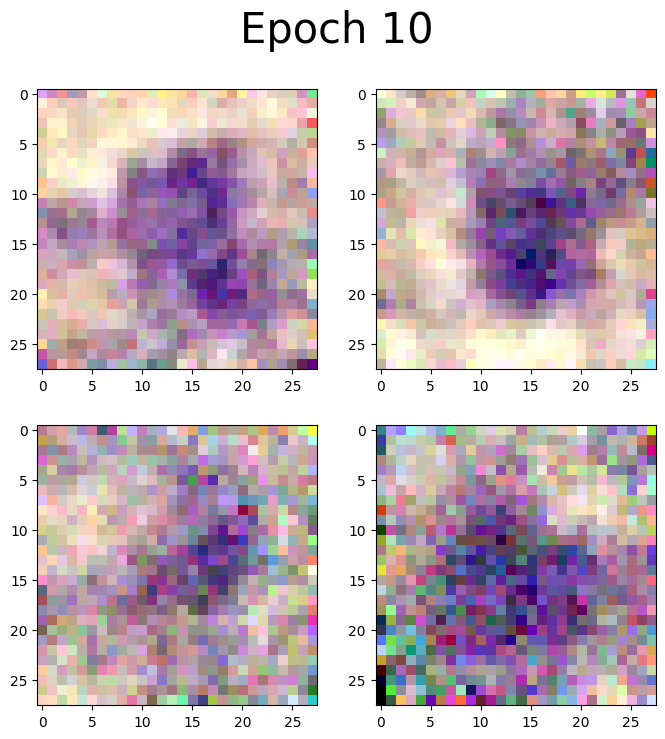

Epoch 10: Loss = 0.1207
Epoch 11: Loss = 0.1156
Epoch 12: Loss = 0.1092
Epoch 13: Loss = 0.1040
Epoch 14: Loss = 0.1016
Epoch 15: Loss = 0.0969
Epoch 16: Loss = 0.0922
Epoch 17: Loss = 0.0927
Epoch 18: Loss = 0.0909
Epoch 19: Loss = 0.0874


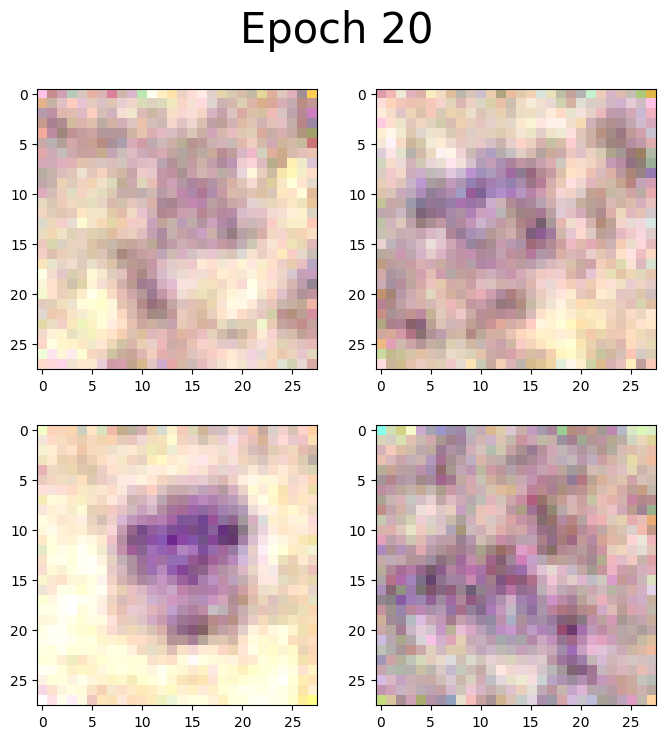

Epoch 20: Loss = 0.0821
Epoch 21: Loss = 0.0827
Epoch 22: Loss = 0.0813
Epoch 23: Loss = 0.0807
Epoch 24: Loss = 0.0775
Epoch 25: Loss = 0.0770
Epoch 26: Loss = 0.0763
Epoch 27: Loss = 0.0747
Epoch 28: Loss = 0.0740
Epoch 29: Loss = 0.0728


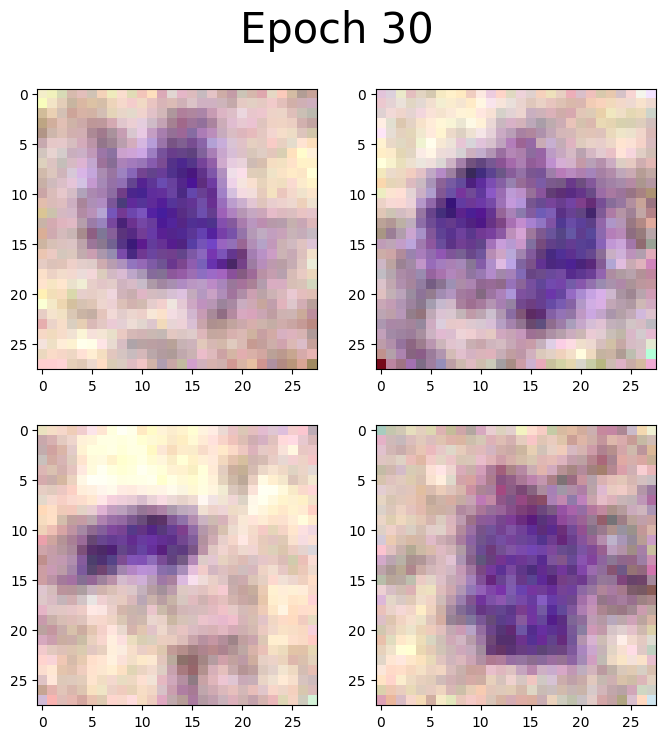

Epoch 30: Loss = 0.0726
Epoch 31: Loss = 0.0710
Epoch 32: Loss = 0.0708
Epoch 33: Loss = 0.0696
Epoch 34: Loss = 0.0690
Epoch 35: Loss = 0.0674
Epoch 36: Loss = 0.0664
Epoch 37: Loss = 0.0674
Epoch 38: Loss = 0.0656
Epoch 39: Loss = 0.0653


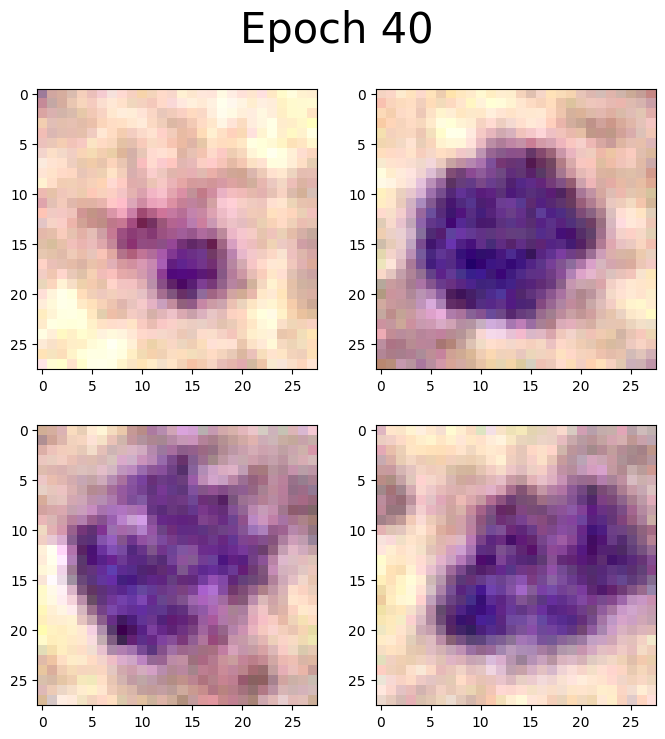

Epoch 40: Loss = 0.0647
Epoch 41: Loss = 0.0652
Epoch 42: Loss = 0.0652
Epoch 43: Loss = 0.0624
Epoch 44: Loss = 0.0616
Epoch 45: Loss = 0.0621
Epoch 46: Loss = 0.0634
Epoch 47: Loss = 0.0621
Epoch 48: Loss = 0.0606
Epoch 49: Loss = 0.0614


In [8]:
# Training
training_loop(ddpm, dataloader, n_epochs, optim=torch.optim.Adam(ddpm.parameters(), lr), device=device, display=True)

In [9]:
# Loading the trained model
checkpoint = torch.load("ddpm_model.pt", map_location=device)

best_model = MyDDPM(
    FixedUNet(n_steps=checkpoint.get('n_steps', n_steps), in_channels=channels), 
    n_steps=checkpoint.get('n_steps', n_steps), 
    device=device,
    image_chw=checkpoint.get('image_chw', (channels, dim_1, dim_2))
)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.eval()

print("Model loaded")

Model loaded


C:\Users\josem\AppData\Local\Temp\ipykernel_16512\3575886735.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("ddpm_model.pt", map_location=device

Generating new images


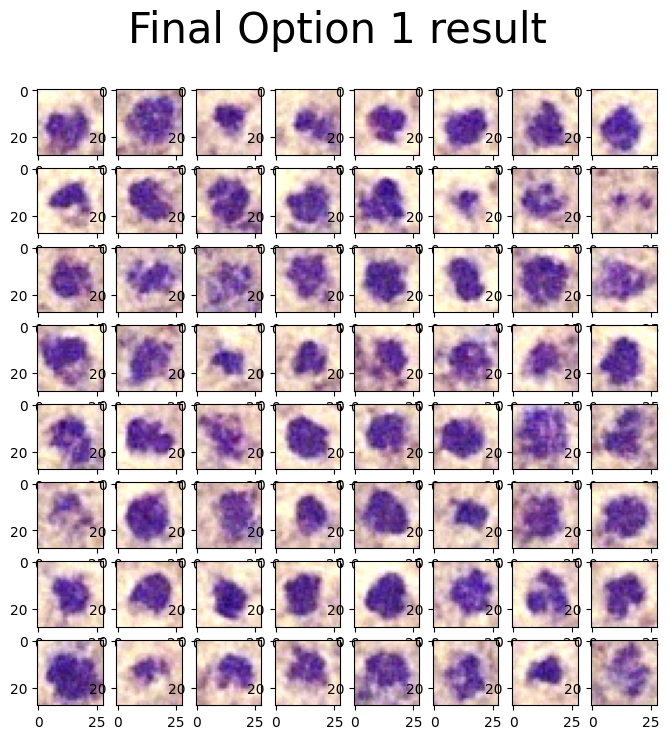

In [10]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        option = 1,
        n_samples=64,# change the number of samples as needed
        device=device,
    )
show_images(generated, "Final Option 1 result")

In [11]:
N_EVAL_SAMPLES = 128

In [16]:
synthetic_samples = ddpm.generate_synthetic_samples(
    n_to_generate=N_EVAL_SAMPLES,
    batch_size=128,
    n_steps=500
)

Generating 128 samples in 1 batches using 500 steps...
Using steps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 2

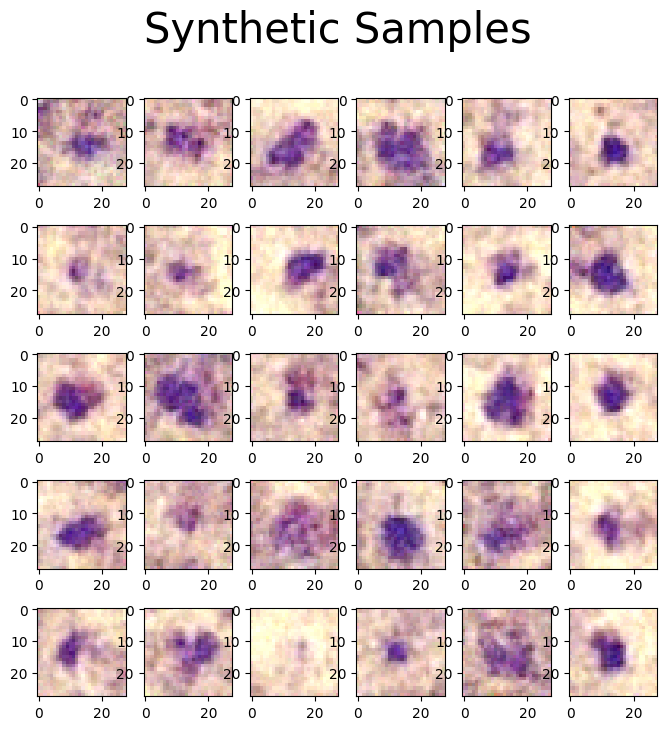

In [17]:
# visualize 32 samples
show_images(synthetic_samples[:32], "Synthetic Samples")



In [18]:
from torch.utils.data import DataLoader, RandomSampler, ConcatDataset
# **************************************
# Wrapper to use pytorch_fid's fid_score() with in-memory images
import pytorch_fid_wrapper as pfw

def get_fid():
    random_sampler = RandomSampler(
                dataloader, num_samples=N_EVAL_SAMPLES)

    eval_dataloader = DataLoader(
                dataset=dataset, batch_size=128, sampler=random_sampler)
    eval_tensor = torch.cat(
                [batch[0] for batch in eval_dataloader], dim=0)


    # 4. Compute Frechet Inception Distance (FID) between real and synthetic
    pfw.set_config(batch_size=10, dims=2048, device="cuda" if torch.cuda.is_available() else "cpu")
    # print(f"Real samples shape: {eval_tensor.shape}")
    # print(f"Fake samples shape: {synthetic_samples.shape}"
    fid = pfw.fid(fake_images=synthetic_samples,
                real_images=eval_tensor)
    print(f"FID:{fid}")
    
    return fid


In [19]:
import random

import numpy as np


EVAL_SEEDS = [100, 200, 300, 400, 500]


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)
    
    
fid_scores = []

for seed in EVAL_SEEDS:
    set_seed(seed)    
    fid_score = get_fid()
    print(f"FID score for seed {seed}: {fid_score}")
    fid_scores.append(fid_score)

FID:373.4140507879059
FID score for seed 100: 373.4140507879059
FID:377.6019899185306
FID score for seed 200: 377.6019899185306
FID:376.72529323531546
FID score for seed 300: 376.72529323531546
FID:377.1087041388379
FID score for seed 400: 377.1087041388379
FID:377.59477197413077
FID score for seed 500: 377.59477197413077
